<a href="https://colab.research.google.com/github/MiguelAngel-ht/Cells-Classification/blob/main/Final-Code/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Basic libraries 
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [ ]:
# Big plots 
import plotly.express as px

In [ ]:
def show_images(images, names):
  """
            FUNCTION THAT PLOT ALL OF IMAGES TOGETHER
      args:
            images (list of arrays) - List with images to plot
            names (list of strings) - List of respective titles
      
  """

  # size in function of amount of images
  fig, axs = plt.subplots(1, len(names), figsize=(4*len(names), 6), constrained_layout=True)

  # create every plot in one
  for i, (ax, img) in enumerate(zip(axs.flat, images)):
    ax.set_title(names[i])
    ax.imshow(img, 'gray')

  plt.show()

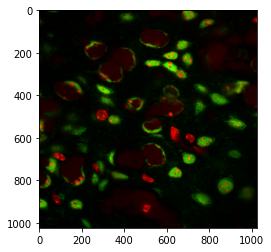

In [ ]:
# Reading first image
img = cv.imread('63x-NeuN-Hoechst-izq-18 ZEN.tif')
plt.imshow(img)
plt.show()

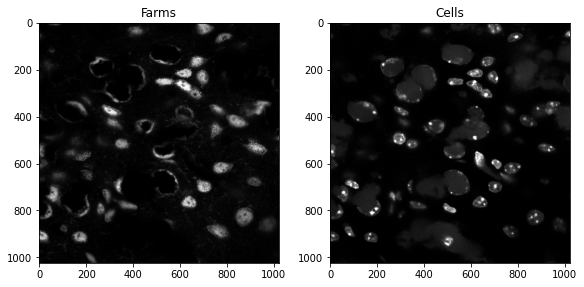

In [ ]:
# separate into 2 components (cells and drugs)
imgF = img[:,:,1] 
imgC = img[:,:,0]
show_images([imgF, imgC], ['Drugs', 'Cells'])

In [ ]:
# Morphological transforms with cells image

# Blurring 
imgC_bl = cv.boxFilter(imgC, -1, (6, 6))

# Threshold 
imgC_um = cv.threshold(imgC_bl, 17, 255, cv.THRESH_BINARY)[1]

# Opening
kernel = np.ones((9, 9))     
imgC_op = cv.morphologyEx(imgC_um, cv.MORPH_OPEN, kernel)

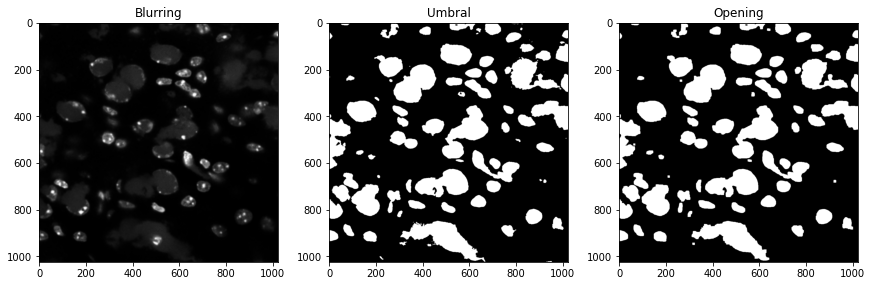

In [ ]:
# Showing the process of filtering
show_images([imgC_bl, imgC_um, imgC_op], ['Blurring', 'Umbral', 'Opening'])

In [ ]:
# Morphological and aritmetic transforms with cells image

# Logarithm transform
c = 255 / np.log(1 + np.max(imgC))
imgC_log = c * np.log(imgC + 1)
imgC_log = imgC_log.astype('uint8')

# Threshold 
imgC_um2 = np.copy(imgC_log)
imgC_um2[imgC_um2 > 140] = 255
imgC_um2[imgC_um2 != 255] = 0

# Opening and Dilate
kernel = np.ones((2,2),np.uint8) 
imgC_op1 = cv.morphologyEx(imgC_um2, cv.MORPH_OPEN, kernel)
kernel = np.ones((3,3),np.uint8) 
imgC_dl = cv.dilate(imgC_op1, kernel, iterations = 1)

# Opening
kernel = np.ones((5,5))     
imgC_op2 = cv.morphologyEx(imgC_dl, cv.MORPH_OPEN, kernel)

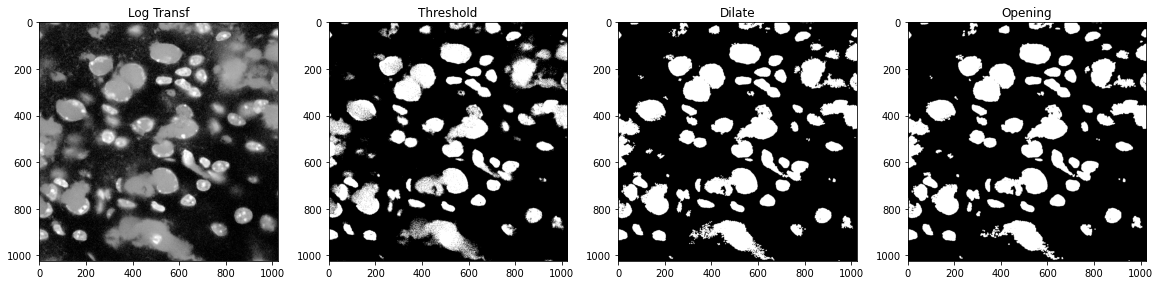

In [ ]:
# Showing the process of filtering
show_images([imgC_log, imgC_um2, imgC_dl, imgC_op2],
            ['Log Transf', 'Threshold', 'Dilate', 'Opening'])

In [ ]:
# Drug image processing

# Smooting 
kernel = (1 / (5*5)) * np.ones((5,5))
imgF_sm = cv.filter2D(imgF, -1, kernel)

# Thresholding
imgF_th = cv.threshold(imgF_sm, 26, 255, cv.THRESH_BINARY)[1]

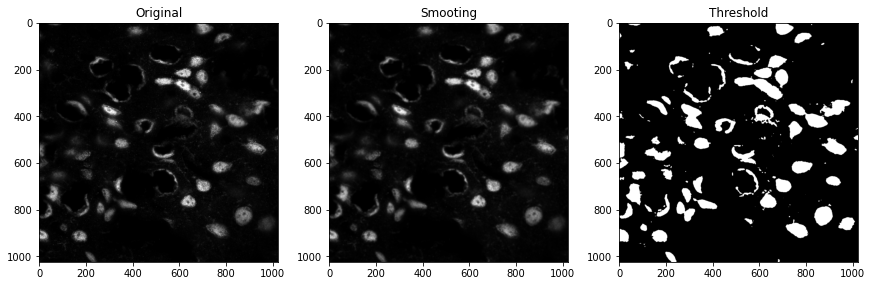

In [ ]:
# Showing the process of filtering
show_images([imgF, imgF_sm, imgF_th], 
            ['Original', 'Smooting', 'Threshold'])

In [ ]:
def Classifier(imgC, imgF, inf, sup, q=False):
  """
        This function classifier the cells image in function of drug image into 3 classes 
        acording to a thresholding.

        Args:
              imgC (Array) - Image with cells segmented
              imgF (Array) - Image with drugs segmented
              inf (float)  - Bottom limit of thresholding area
              sup (float)  - Upper limit of thresholding area
        Return:
              clas (Array) - Image with the 3 classified groups
              label (Array) - Image with every cell labeled 
    """

  areasC = []
  areasF = []
  clas = np.zeros(np.shape(imgC))

  # label cells of cell images
  num, label, stats, centroids = cv.connectedComponentsWithStats(imgC, cv.CV_32S)

  # if there are liquid in the image, delete it
  if q:
    hist = np.histogram(label.flatten(), num+1)[0][1:]
    label[label == hist.argmax()] = 0

  # classification of every cell 
  for i in range(num+1)[1:]:

    cells = label == i
    areaC = np.count_nonzero(cells*255 == 255)
    farms = cells * imgF
    areaF = np.count_nonzero(farms == 255)
    
    # thresholding areas to classify
    if areaF >= inf * areaC:
      a = 3
    if areaF >= inf * areaC and areaF < sup * areaC:
      a = 2
    if areaF < inf * areaC:
      a = 1

    # adding to the final image
    clas  += a * cells 
  
  return clas, label

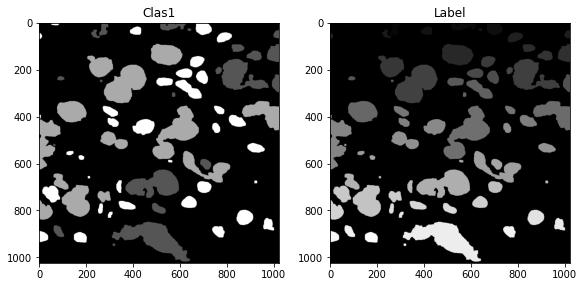

In [ ]:
# Classification of first segmentation
img_cls, label = Classifier(imgC_op, imgF_th, 0.15, 0.5)
show_images([img_cls, label],['Clas1','Label'])

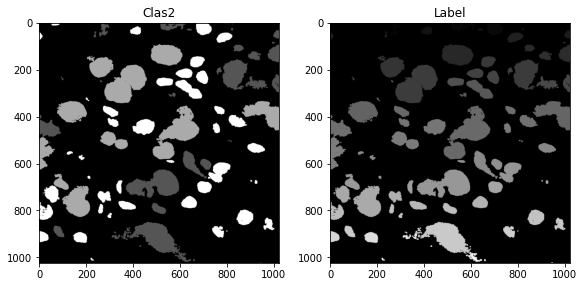

In [ ]:
# Classification of second segmentation
img_cls, label = Classifier(imgC_op2, imgF_th, 0.15, 0.5)
show_images([img_cls, label],['Clas2','Label'])